The purpose of this code is to count the nuclei, the size and number of synuclein inclusions in the PFF experiments.

Import Libraries

In [88]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import remove_small_objects, binary_dilation, disk, binary_closing
from skimage.measure import label, regionprops
from skimage import exposure
import czifile
import math

In [89]:
from skimage import io
from matplotlib import pyplot as plt

def show_image(image):
    """Display image"""
    io.imshow(image)
    plt.show()

Define Sub Functions

In [96]:


def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_czi_image(image_path, dapi_channel_idx=1, green_channel_idx=0):
    """Load and extract dapi, green, and red channel data from a CZI file."""
    czi_file = czifile.CziFile(image_path)
    czi_data = czi_file.asarray()
    dapi_channel_data = np.squeeze(czi_data[:, :, dapi_channel_idx, :, :, :])
    
    green_channel_data = np.squeeze(czi_data[:, :, green_channel_idx, :, :, :])
    
    return dapi_channel_data, green_channel_data


def otsu_thresholding(channel):
    """Apply Otsu's thresholding and morphological closing to the channel."""
    threshold_value = threshold_otsu(channel)
    binary_image = channel > threshold_value
    show_image(binary_image)
    closed_image = binary_closing(binary_image, disk(3))
    labeled_image = label(closed_image)
    return labeled_image

def calculate_surface_area(labeled_image, channel):
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image, channel)
    return sum(prop.area for prop in props)

def preprocess_dapi_channel(dapi_channel):
    """Preprocess the DAPI channel for nuclei quantification."""
    blurred_dapi = gaussian(dapi_channel, sigma=2)
    threshold_value = threshold_otsu(blurred_dapi)
    binary_image = blurred_dapi > threshold_value
    show_image(binary_image)
    cleaned_image = remove_small_objects(binary_image, min_size=400)
    merged_image = binary_dilation(cleaned_image, footprint=disk(5))
    labeled_image = label(merged_image)
    return labeled_image

def count_nuclei(labeled_image):
    """Count the number of nuclei in the labeled image."""
    return len(np.unique(labeled_image)) - 1

def preprocess_green_channel(green_channel):
    """Preprocess the green channel for inclusion quantification."""
    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = (confocal_img - confocal_img.min()) / (confocal_img.max() - confocal_img.min())
    return confocal_img

def threshold_inclusions(confocal_img):
    """Threshold the preprocessed green channel to segment inclusions."""
    threshold = 0.94
    binary_image = confocal_img > threshold
    show_image(binary_image)
    labeled_image = label(binary_image)
    return labeled_image

def measure_inclusion_sizes(labeled_image, confocal_img):
    """Measure the sizes of inclusions."""
    props = regionprops(labeled_image, confocal_img)
    sizes = [prop.area for prop in props]
    return [size for size in sizes if size > 10]

def add_to_dataframe(sizes_df_new, sizes, path):
    """Add sizes of inclusions to the DataFrame."""
    sizes_df_add = pd.DataFrame(sizes, columns=[f'image {path}'])
    if sizes_df_new is None:
        return sizes_df_add
    else:
        return pd.concat([sizes_df_new, sizes_df_add], axis=1)

def calculate_metrics(number_of_nuclei_list, sizes_df_new):
    """Calculate additional metrics and return the second DataFrame."""
    sizes_df_new_nuclei = sizes_df_new.transpose()
    number_of_inclusions = sizes_df_new_nuclei.count(axis=1)
    average_number_of_inclusions = number_of_inclusions / np.array(number_of_nuclei_list)
    
    return pd.DataFrame({
        "number_of_inclusions": number_of_inclusions,
        "Number_of_Nuclei": number_of_nuclei_list,
        "Average_Number_of_Inclusions_per_Cell": average_number_of_inclusions,
    })

def calculate_sizes(sizes_df_new):
    """Return a Dataframe consisting of the sizes of individual inclusion"""
    sizes_df_new = sizes_df_new.transpose()

    # for file_name in sizes_df_new.index:
    #     for count in sizes_df_new.columns:
    #         inclusion_size = sizes_df_new.loc[file_name,count]
    #         if math.isnan(inclusion_size):
    #             continue
    #         data.append({"file_name":file_name,"inclusion_number":count,"inclusion_size":inclusion_size})

    data = [
        {"file_name": file_name, "inclusion_number": count, "inclusion_size": size}
        for file_name in sizes_df_new.index
        for count, size in sizes_df_new.loc[file_name].items()
        if not math.isnan(size)
    ] 
    df = pd.DataFrame(data)
    return df
    



Define Main Function

251024_PFF_SCR_TAX_ADAM\1K_ADAMTS19_01.czi


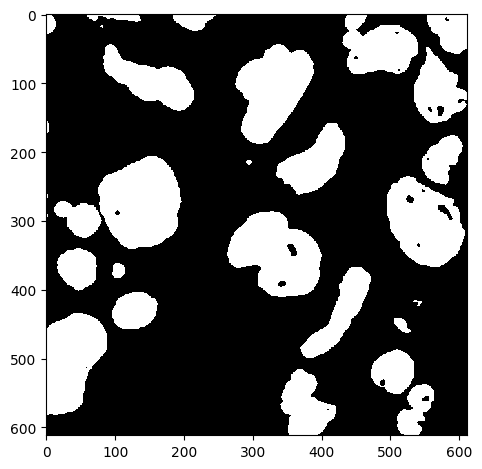

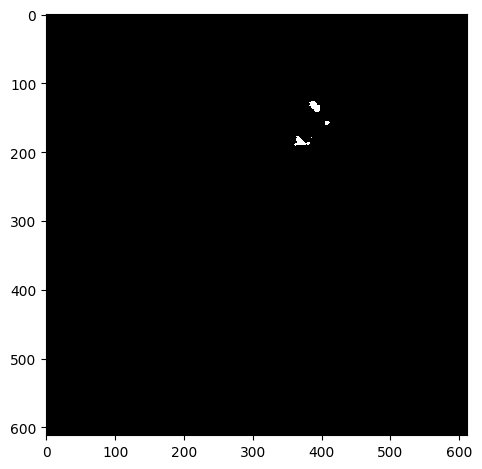

251024_PFF_SCR_TAX_ADAM\1K_ADAMTS19_02.czi


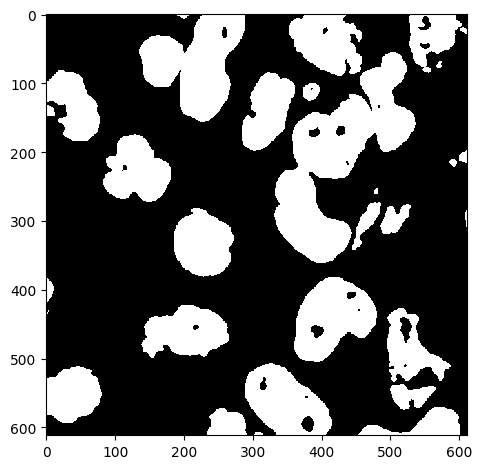

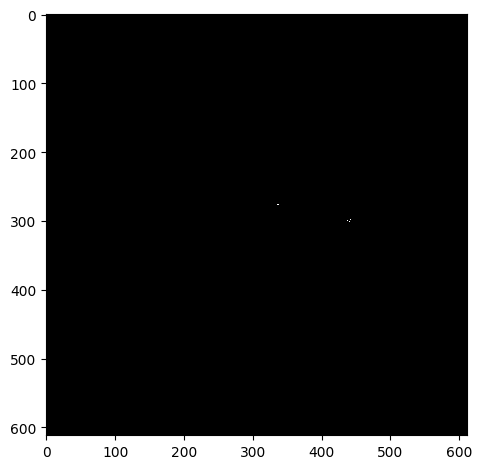

251024_PFF_SCR_TAX_ADAM\1K_ADAMTS19_03.czi


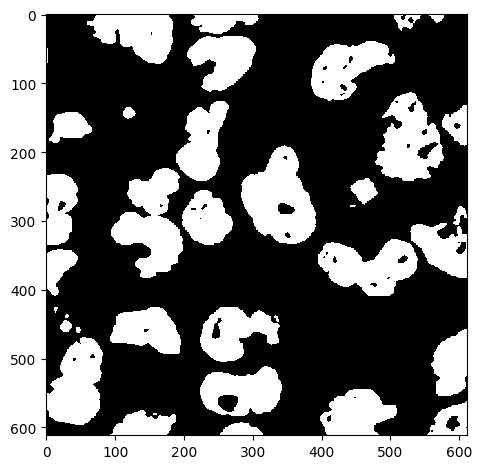

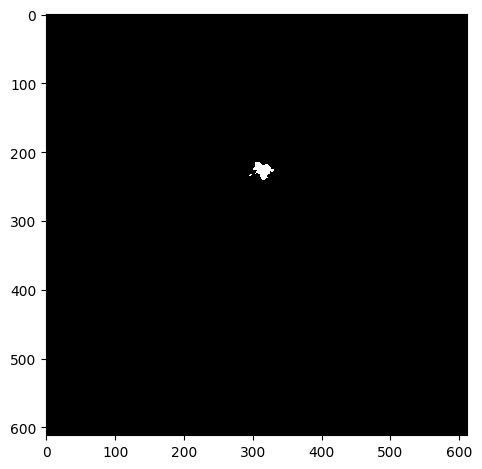

251024_PFF_SCR_TAX_ADAM\1K_ADAMTS19_04.czi


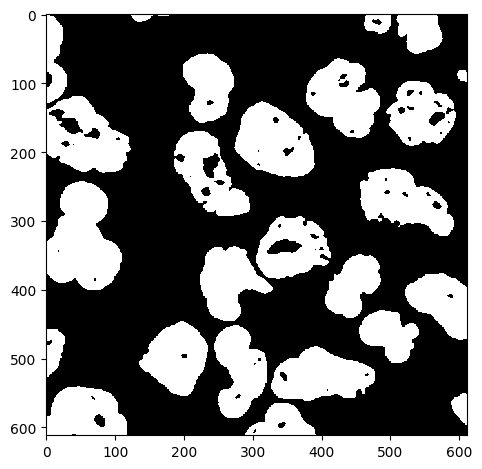

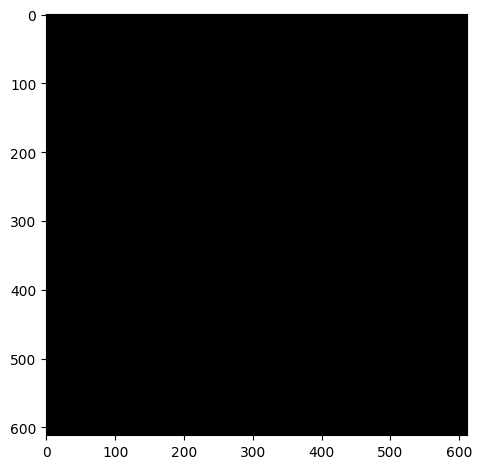

251024_PFF_SCR_TAX_ADAM\1K_ADAMTS19_05.czi


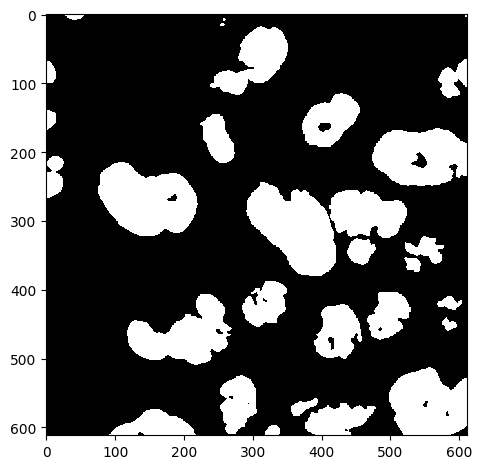

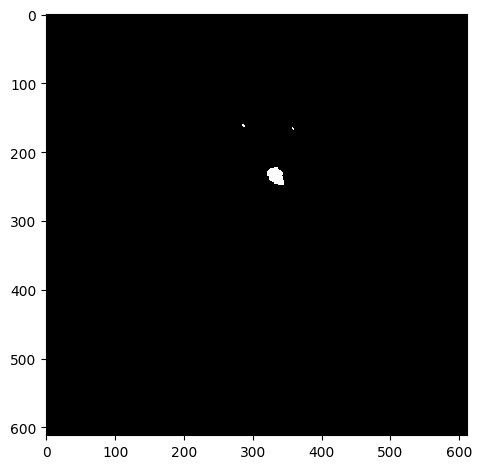

251024_PFF_SCR_TAX_ADAM\1K_ADAMTS19_06.czi


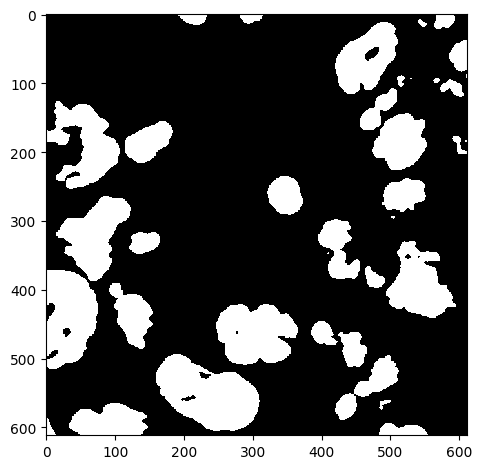

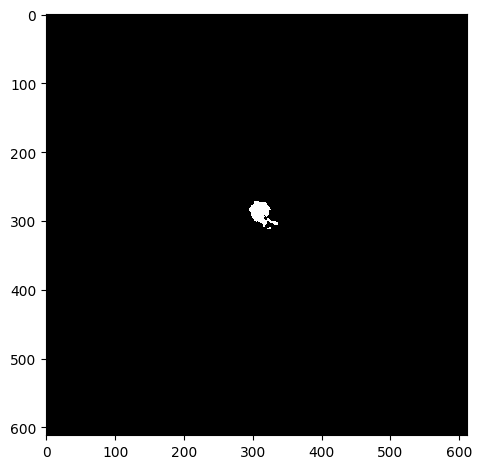

251024_PFF_SCR_TAX_ADAM\1K_ADAMTS19_07.czi


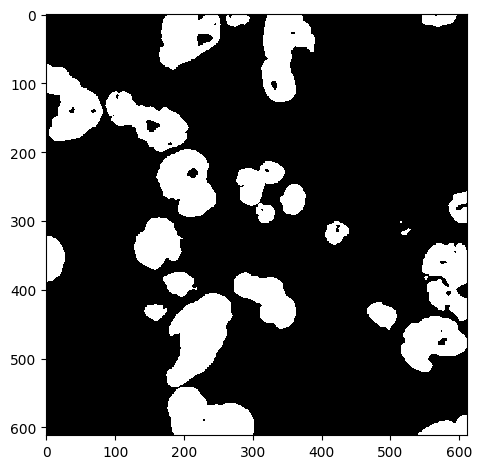

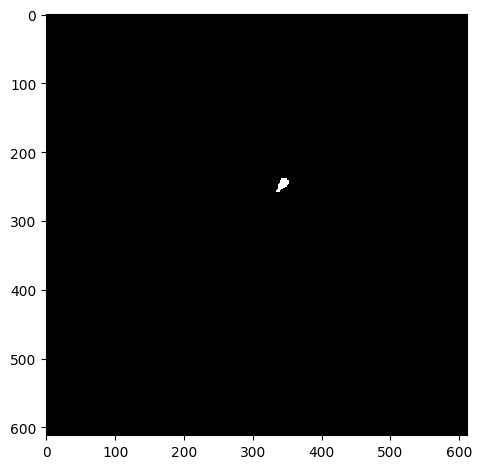

251024_PFF_SCR_TAX_ADAM\1K_ADAMTS19_08.czi


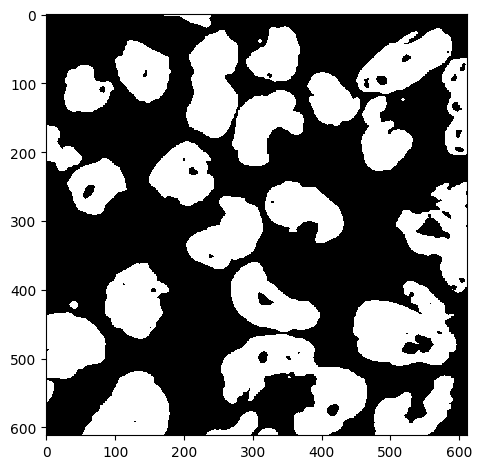

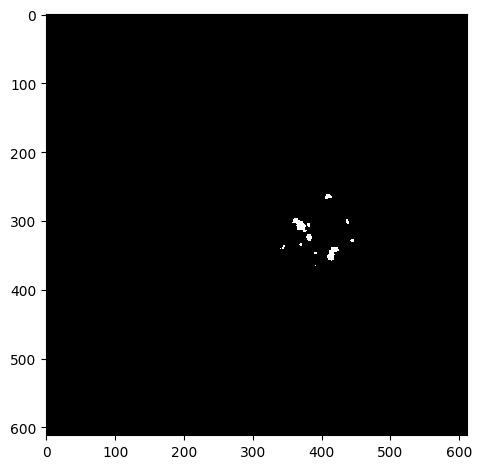

251024_PFF_SCR_TAX_ADAM\1K_ADAMTS19_09.czi


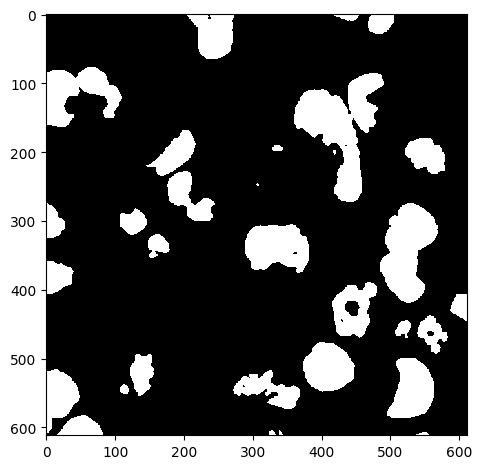

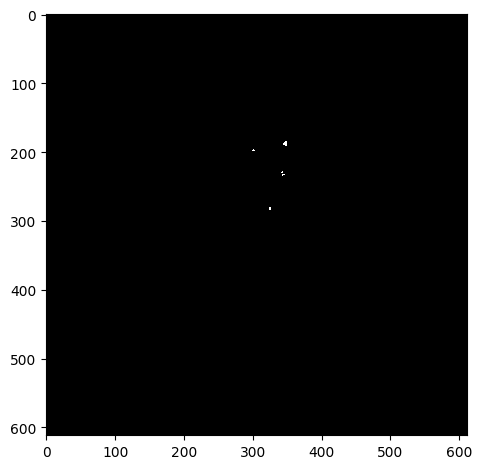

251024_PFF_SCR_TAX_ADAM\1K_ADAMTS19_10.czi


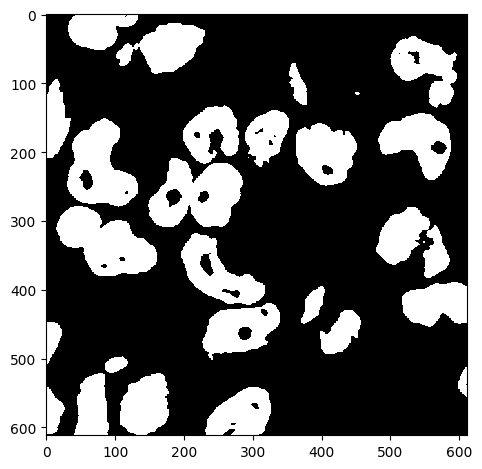

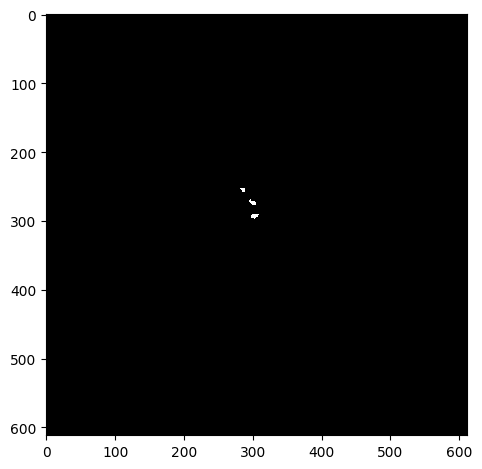

251024_PFF_SCR_TAX_ADAM\1K_SCR_01.czi


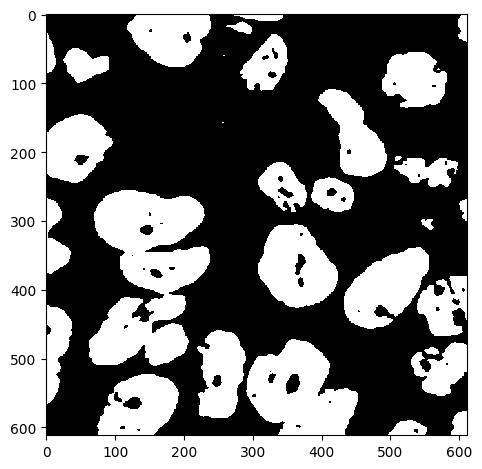

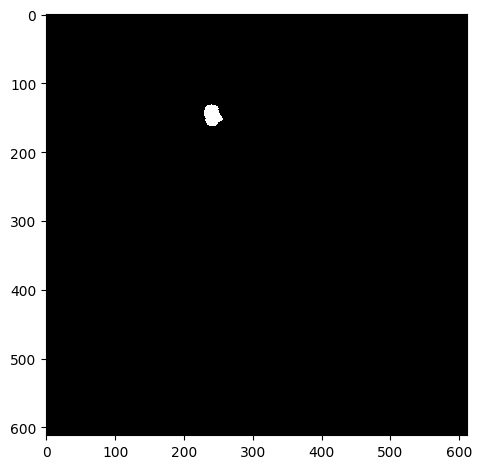

251024_PFF_SCR_TAX_ADAM\1K_SCR_02.czi


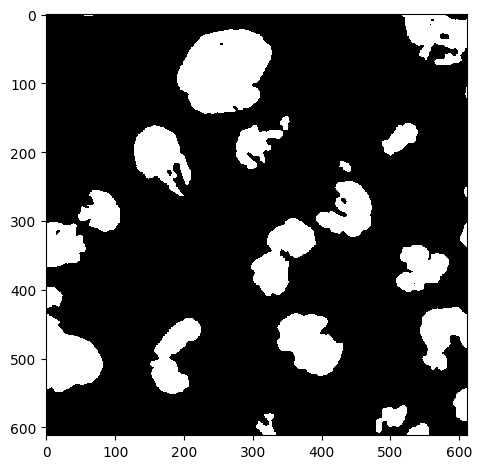

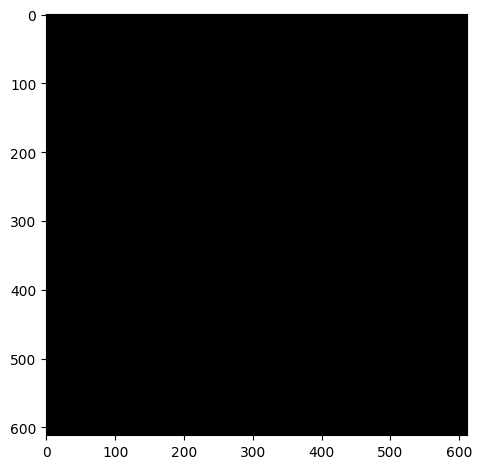

251024_PFF_SCR_TAX_ADAM\1K_SCR_03.czi


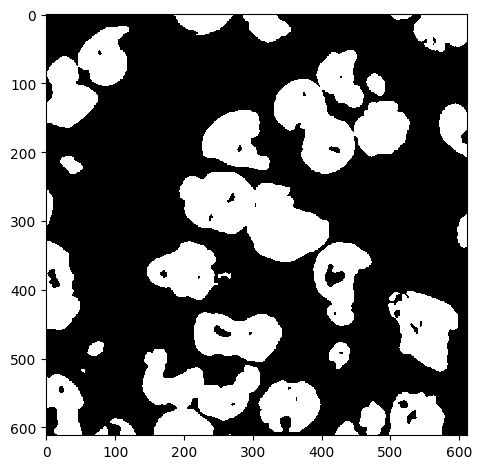

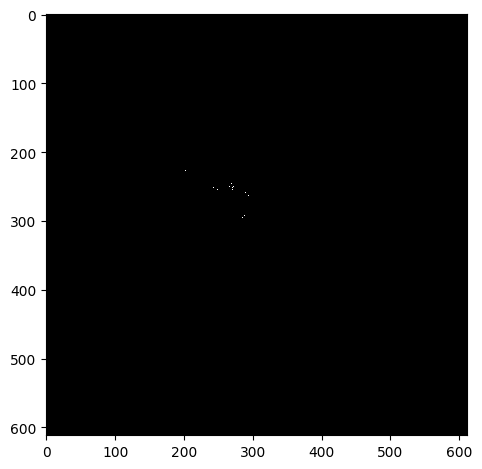

251024_PFF_SCR_TAX_ADAM\1K_SCR_04.czi


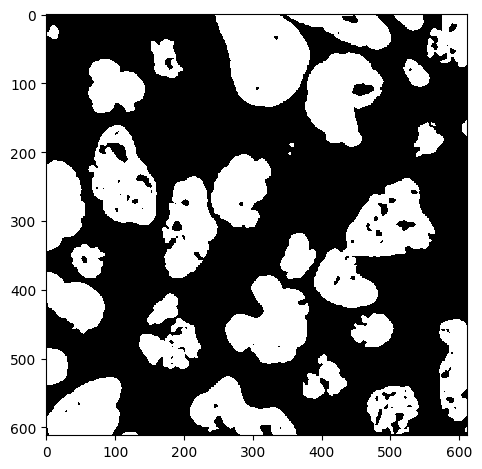

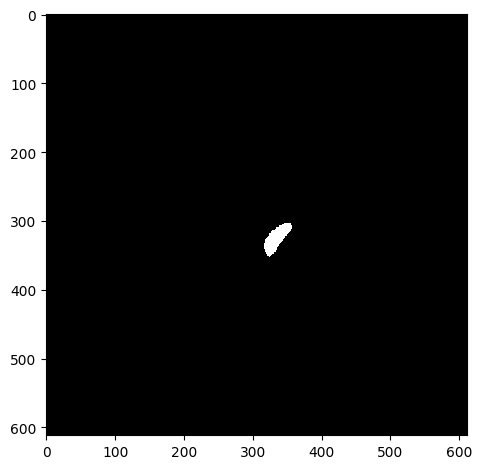

251024_PFF_SCR_TAX_ADAM\1K_SCR_05.czi


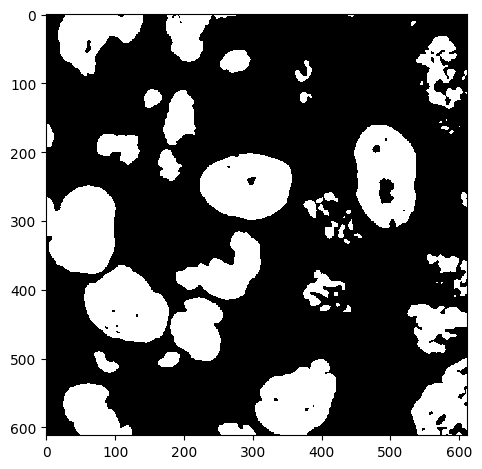

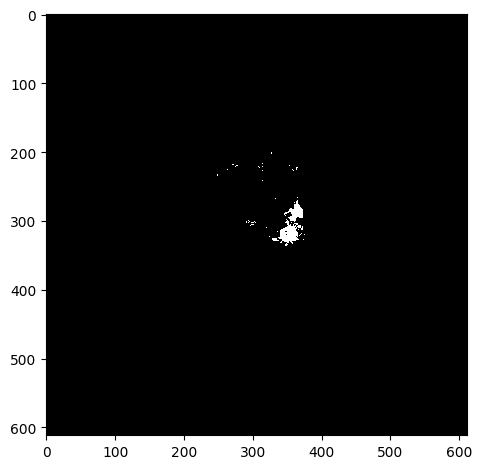

251024_PFF_SCR_TAX_ADAM\1K_SCR_06.czi


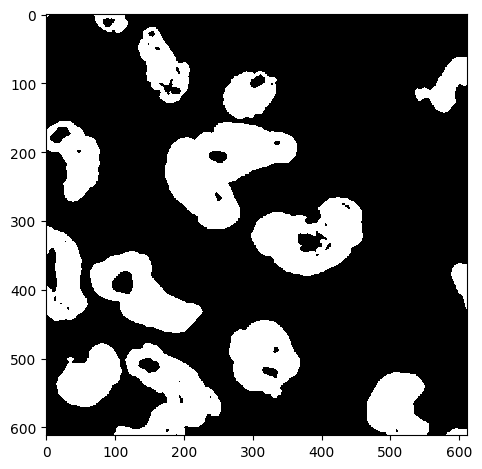

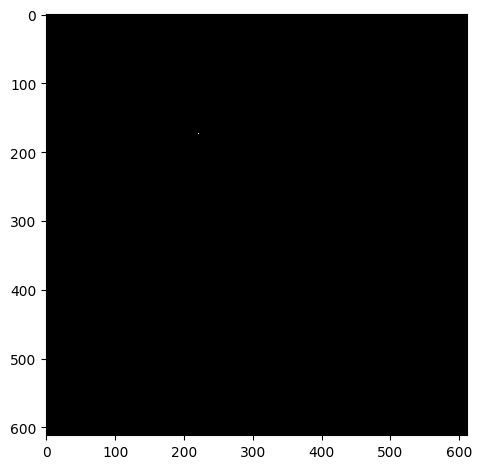

251024_PFF_SCR_TAX_ADAM\1K_SCR_07.czi


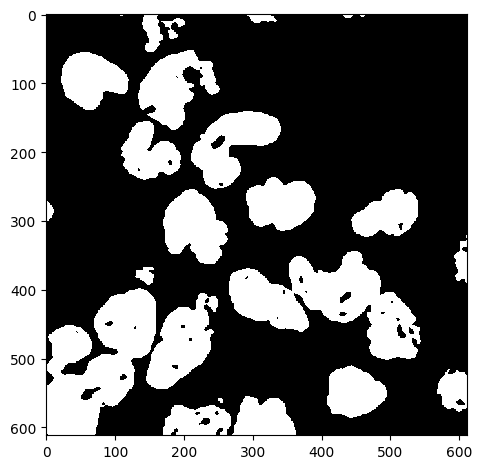

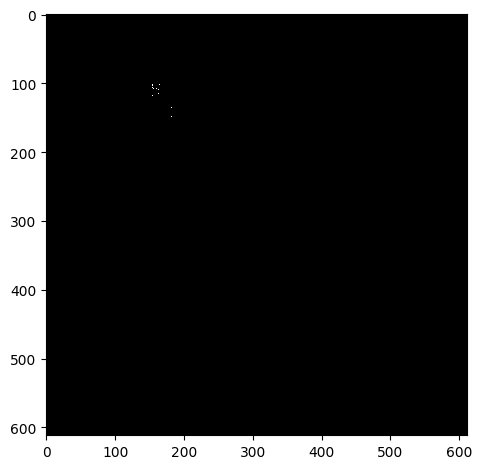

251024_PFF_SCR_TAX_ADAM\1K_SCR_08.czi


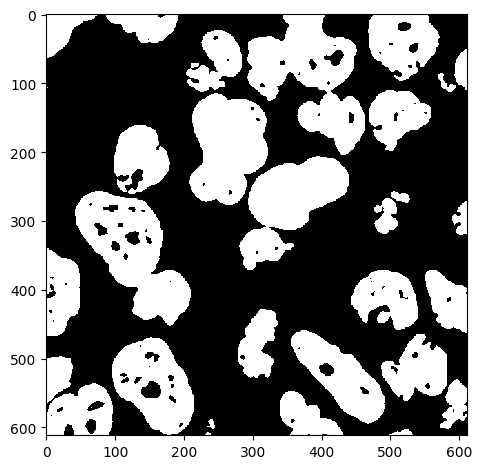

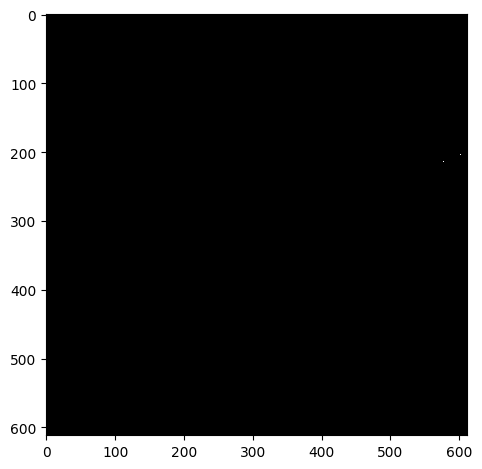

251024_PFF_SCR_TAX_ADAM\1K_SCR_09.czi


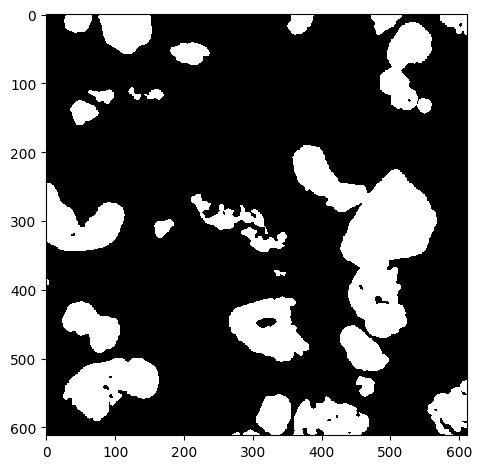

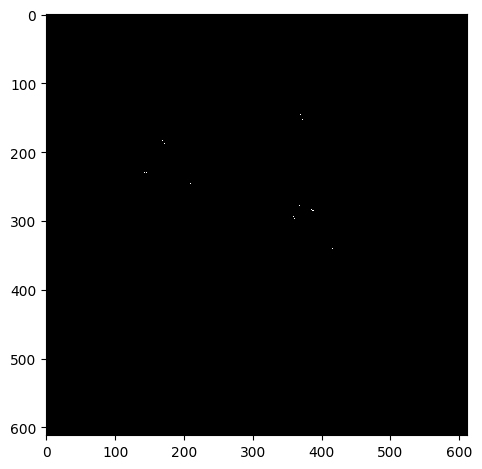

251024_PFF_SCR_TAX_ADAM\1K_SCR_10.czi


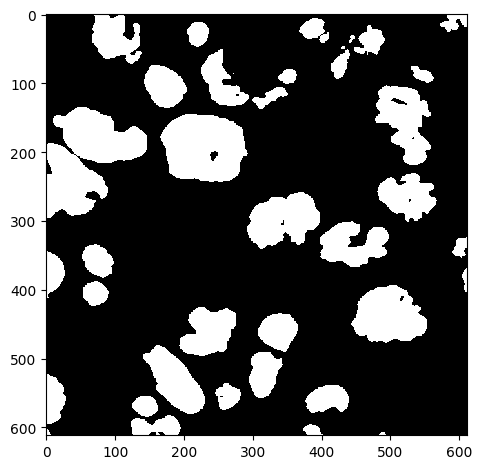

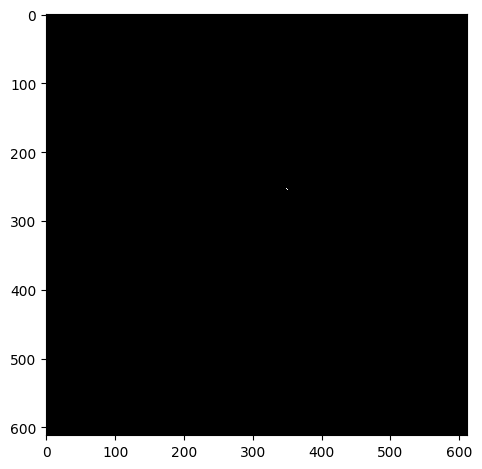

251024_PFF_SCR_TAX_ADAM\1K_TAX1BP1_01.czi


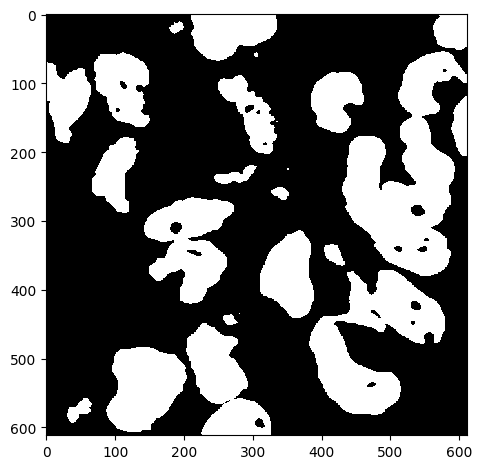

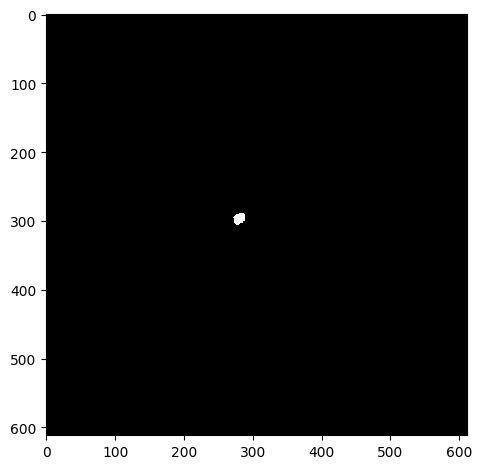

251024_PFF_SCR_TAX_ADAM\1K_TAX1BP1_02.czi


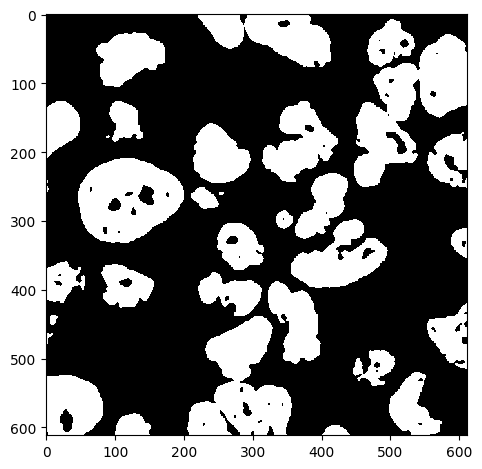

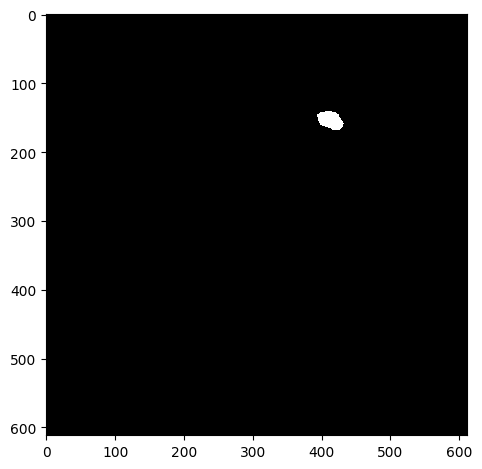

251024_PFF_SCR_TAX_ADAM\1K_TAX1BP1_03.czi


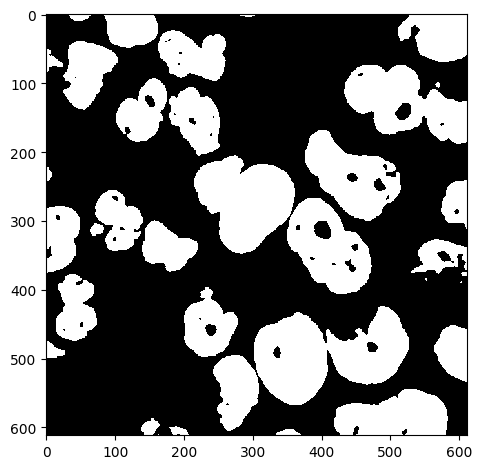

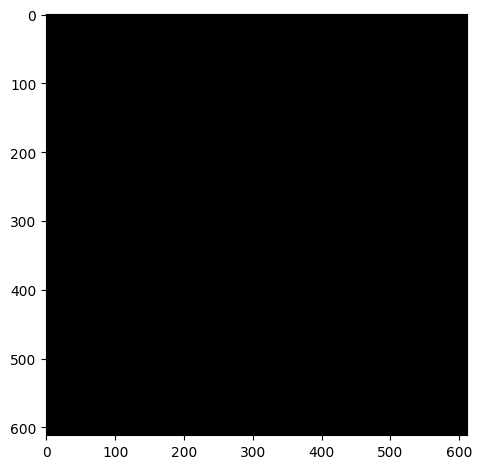

251024_PFF_SCR_TAX_ADAM\1K_TAX1BP1_04.czi


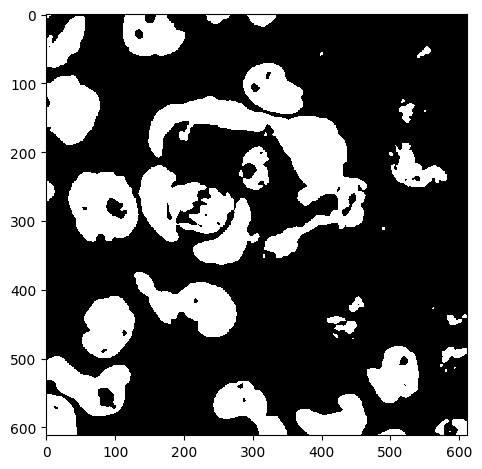

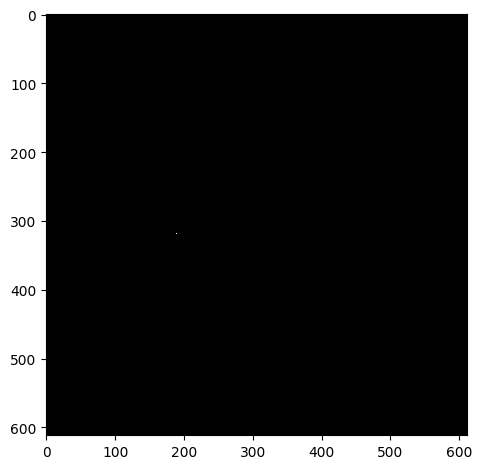

251024_PFF_SCR_TAX_ADAM\1K_TAX1BP1_05.czi


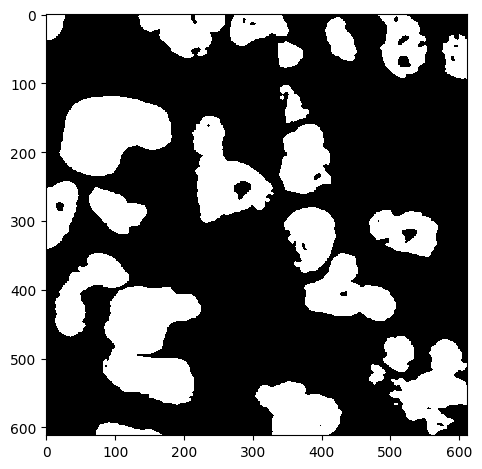

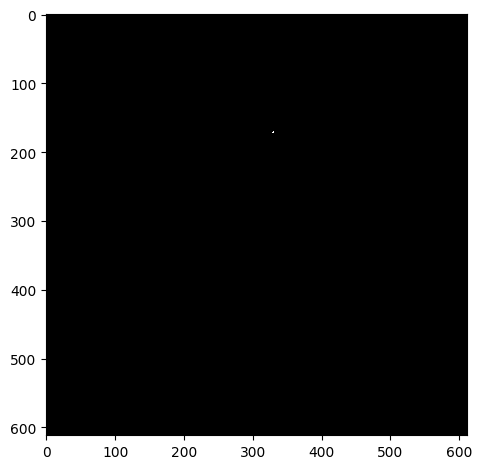

251024_PFF_SCR_TAX_ADAM\1K_TAX1BP1_06.czi


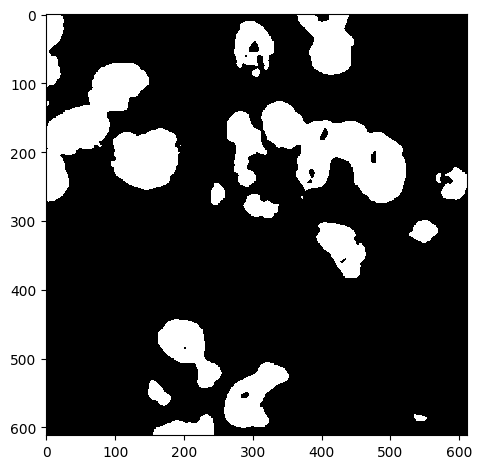

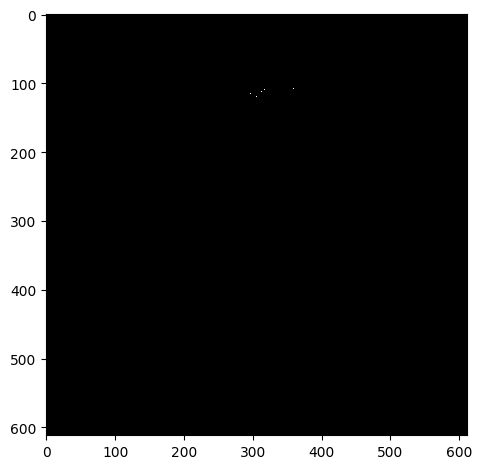

251024_PFF_SCR_TAX_ADAM\1K_TAX1BP1_07.czi


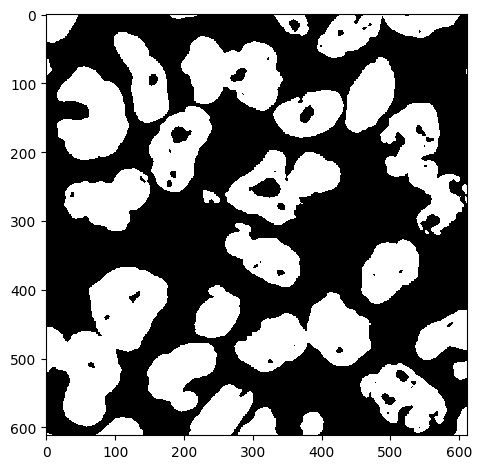

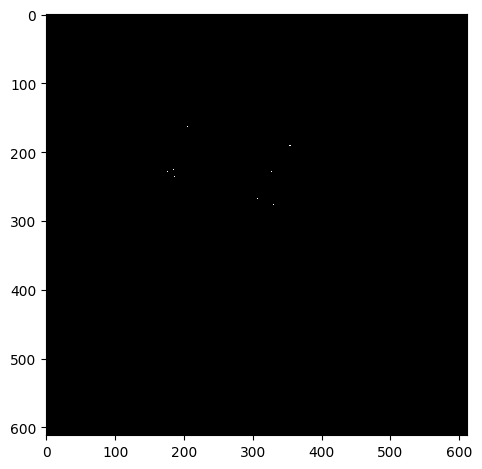

251024_PFF_SCR_TAX_ADAM\1K_TAX1BP1_08.czi


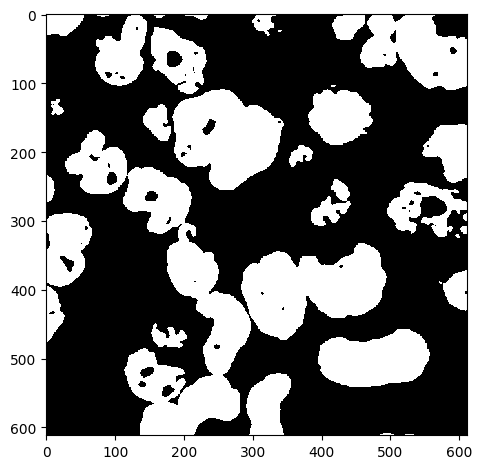

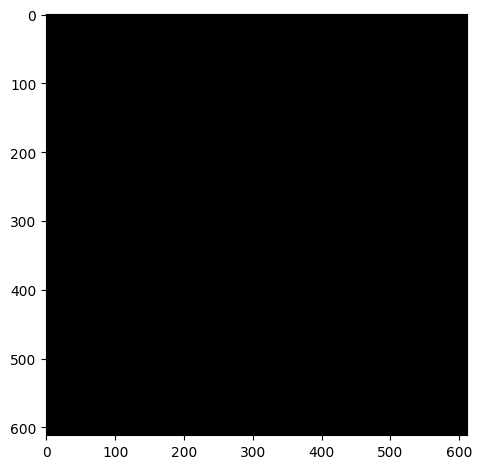

251024_PFF_SCR_TAX_ADAM\1K_TAX1BP1_09.czi


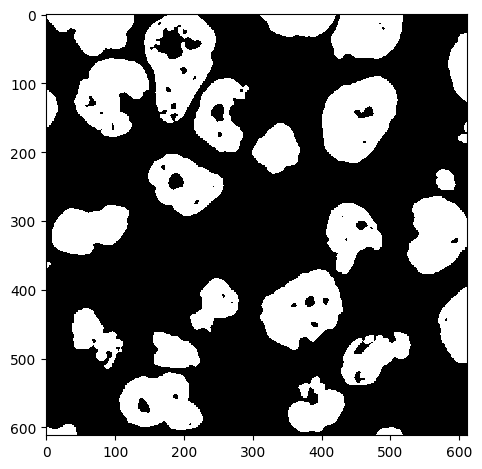

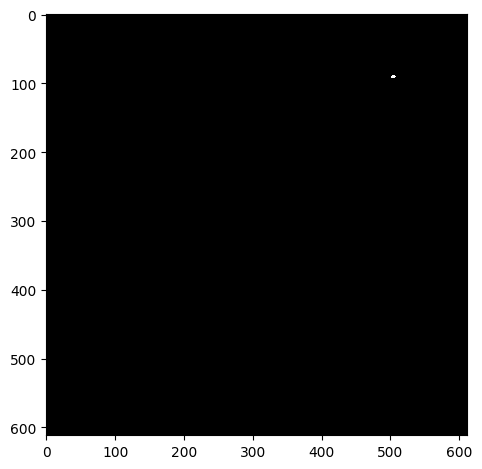

251024_PFF_SCR_TAX_ADAM\1K_TAX1BP1_10.czi


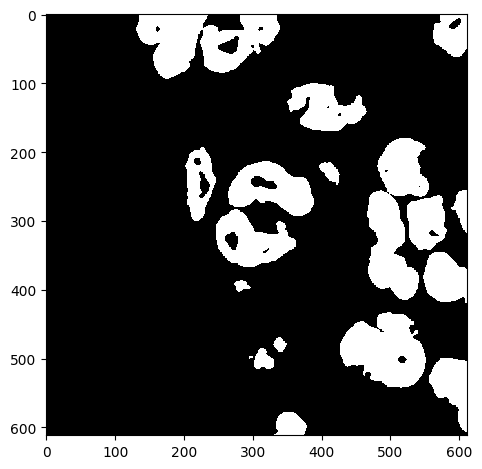

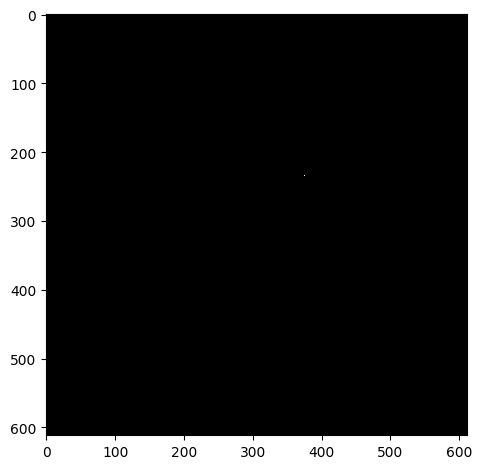

251024_PFF_SCR_TAX_ADAM\WT_ADAMTS19_01.czi


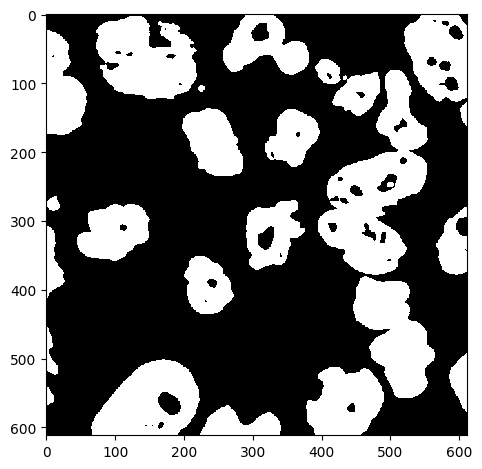

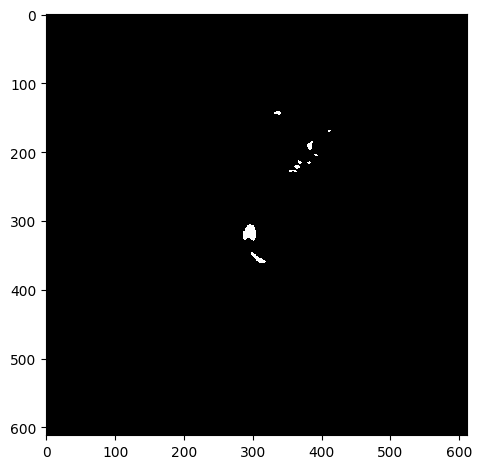

251024_PFF_SCR_TAX_ADAM\WT_ADAMTS19_02.czi


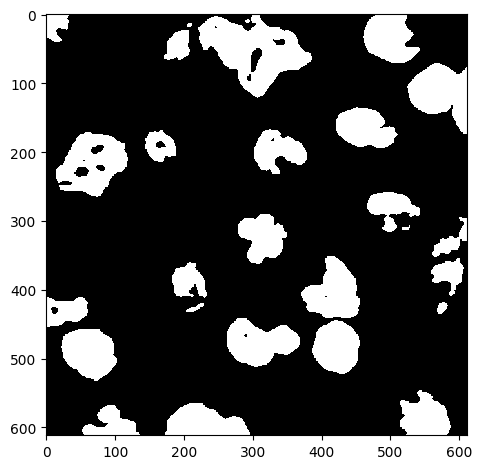

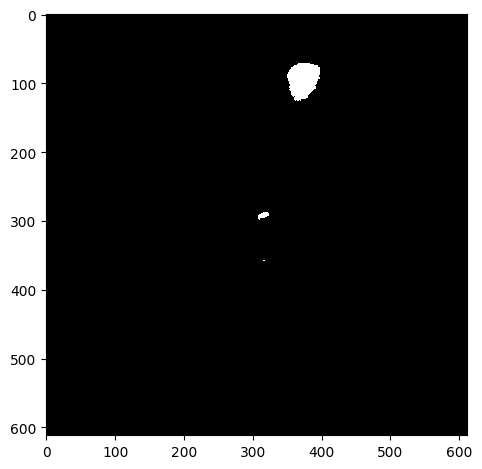

251024_PFF_SCR_TAX_ADAM\WT_ADAMTS19_03.czi


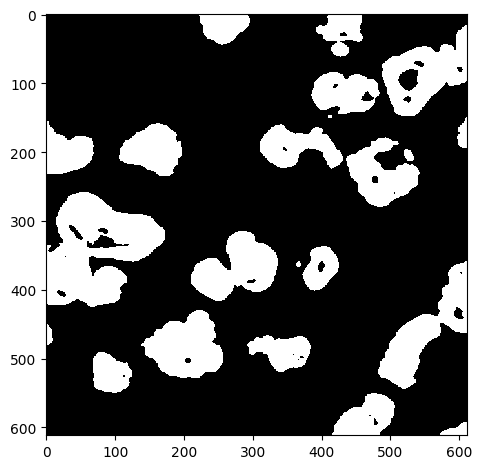

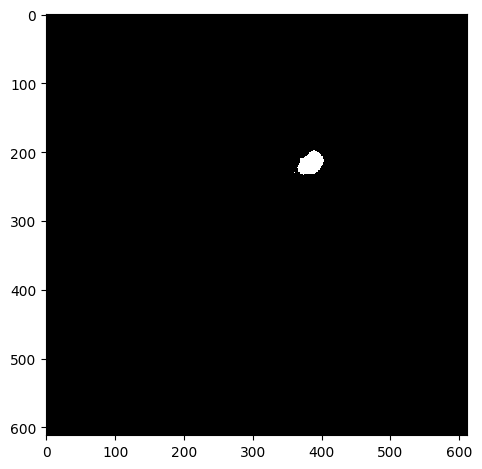

251024_PFF_SCR_TAX_ADAM\WT_ADAMTS19_04.czi


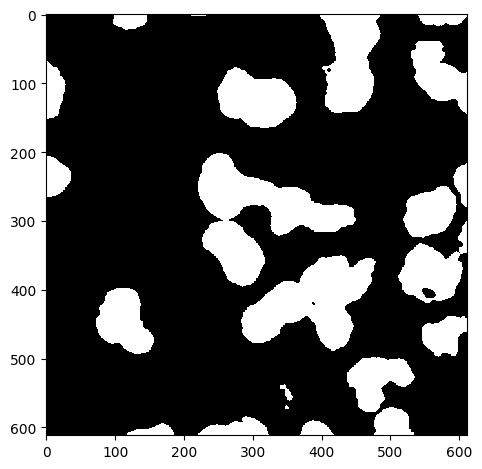

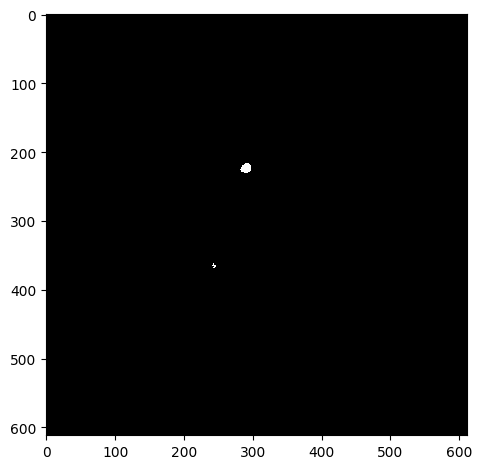

251024_PFF_SCR_TAX_ADAM\WT_ADAMTS19_05.czi


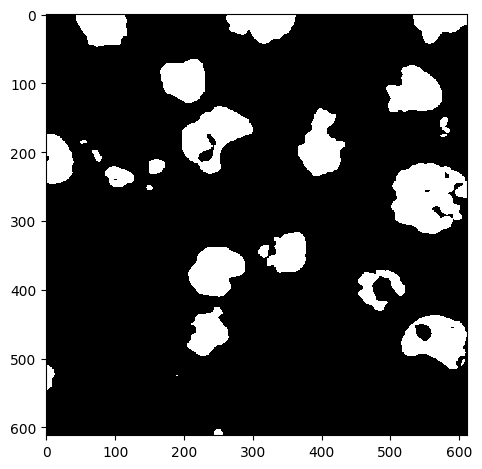

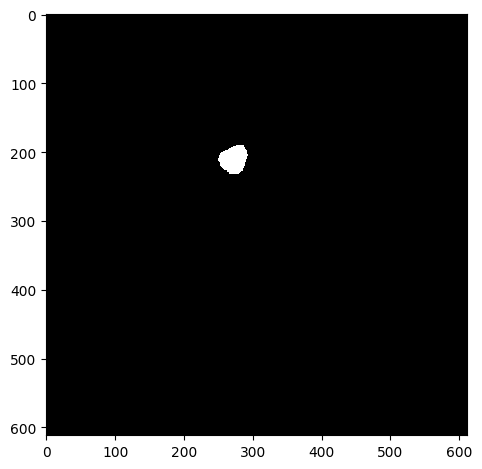

251024_PFF_SCR_TAX_ADAM\WT_ADAMTS19_067.czi


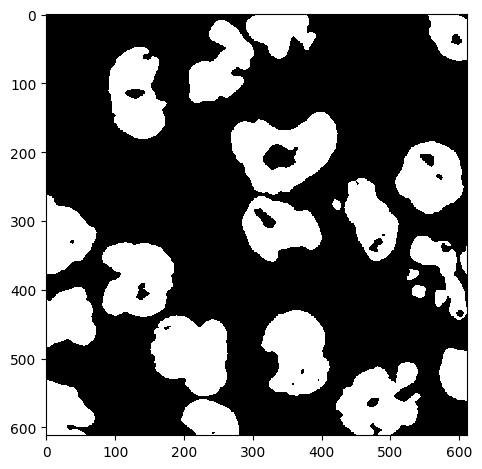

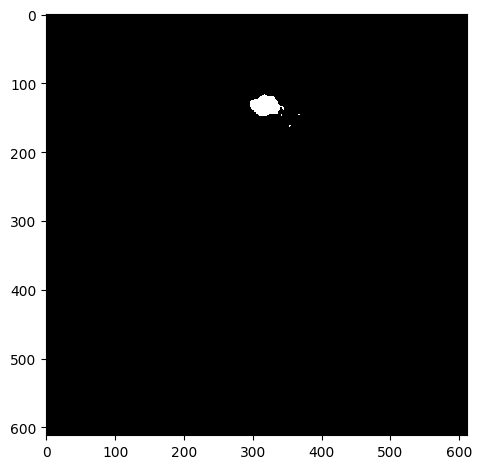

251024_PFF_SCR_TAX_ADAM\WT_ADAMTS19_07.czi


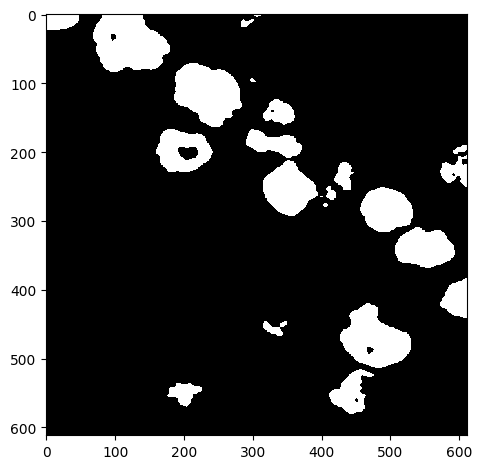

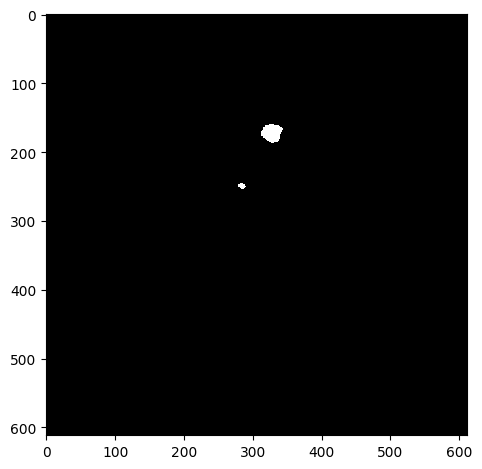

251024_PFF_SCR_TAX_ADAM\WT_ADAMTS19_08.czi


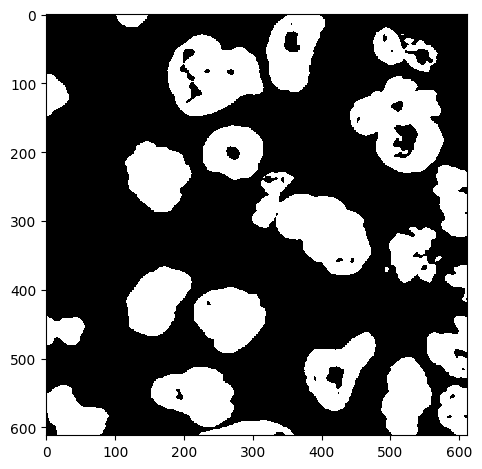

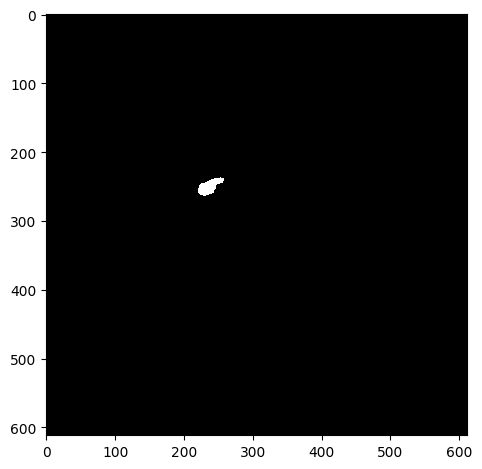

251024_PFF_SCR_TAX_ADAM\WT_ADAMTS19_09.czi


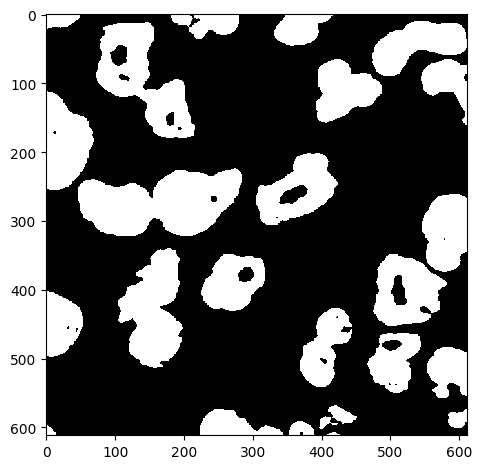

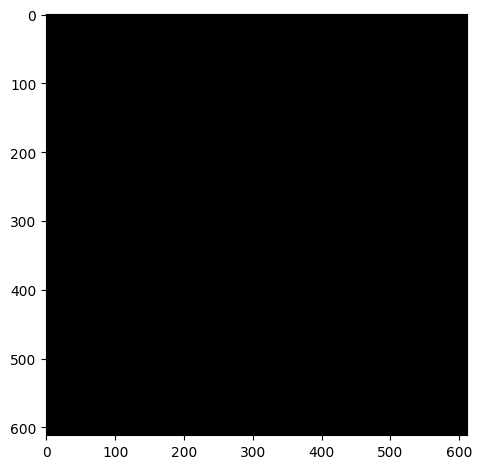

251024_PFF_SCR_TAX_ADAM\WT_ADAMTS19_10.czi


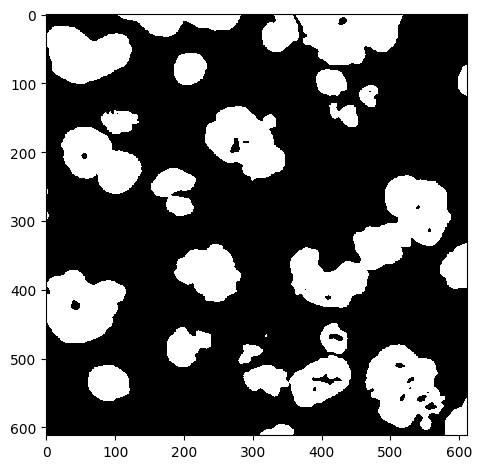

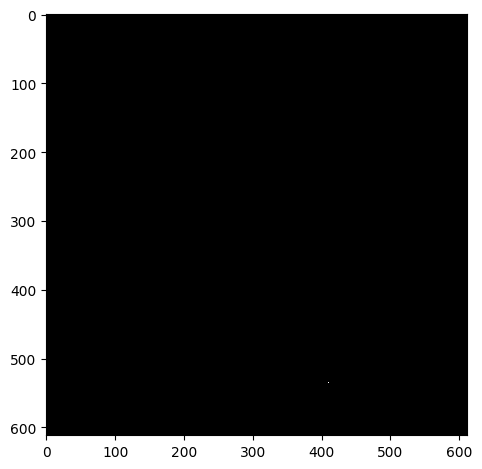

251024_PFF_SCR_TAX_ADAM\WT_SCR_01.czi


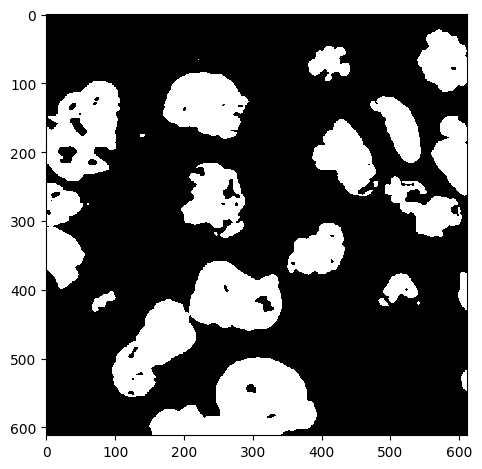

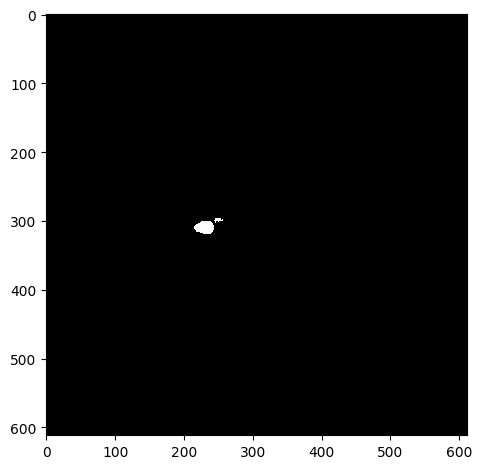

251024_PFF_SCR_TAX_ADAM\WT_SCR_02.czi


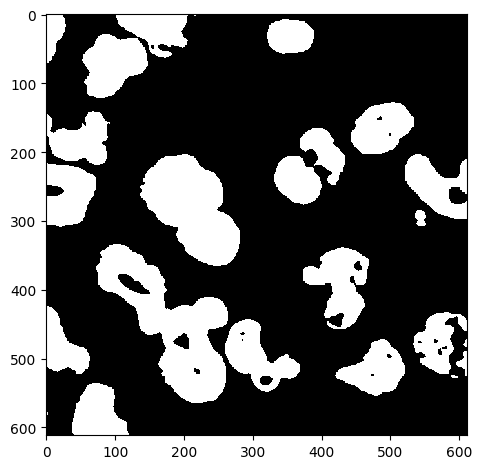

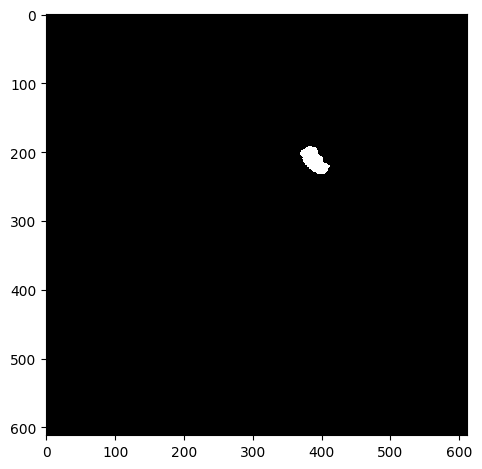

251024_PFF_SCR_TAX_ADAM\WT_SCR_03.czi


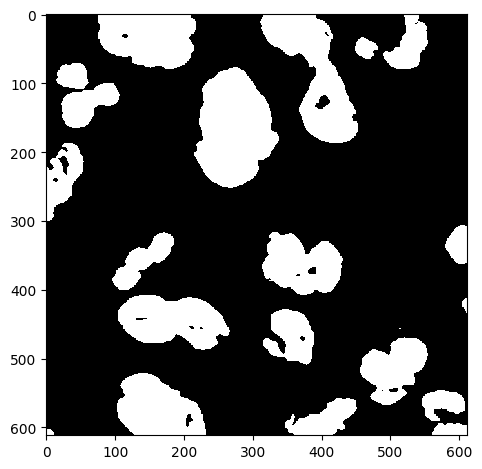

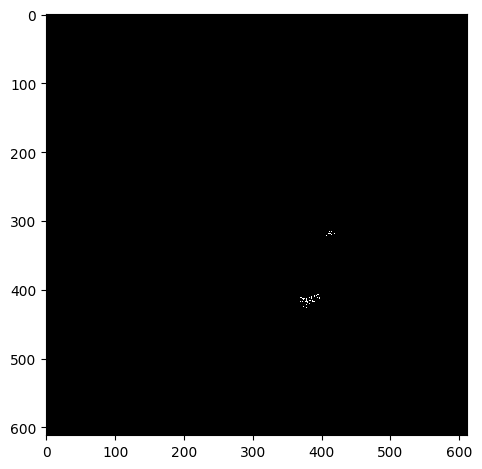

251024_PFF_SCR_TAX_ADAM\WT_SCR_04.czi


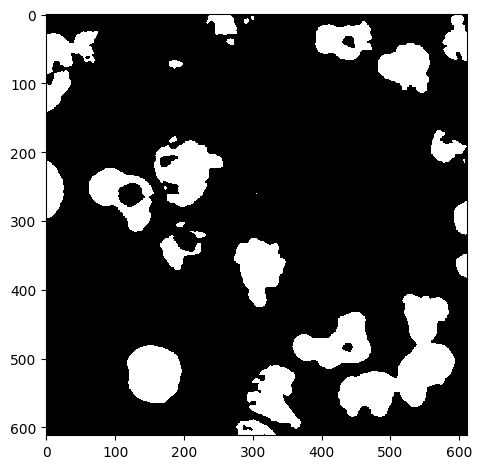

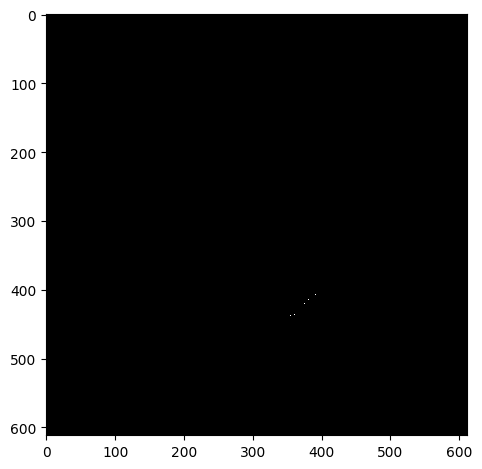

251024_PFF_SCR_TAX_ADAM\WT_SCR_05.czi


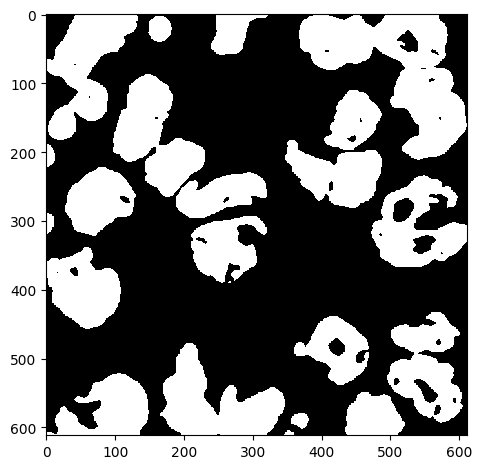

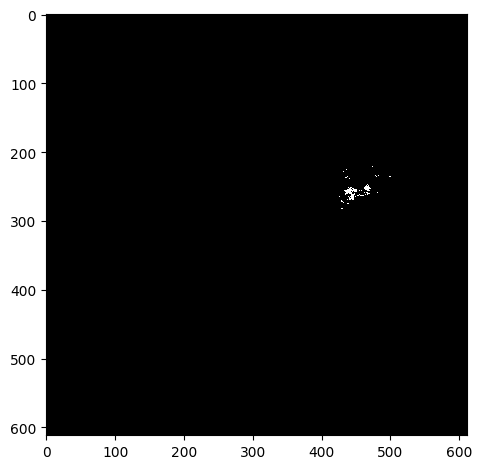

251024_PFF_SCR_TAX_ADAM\WT_SCR_06.czi


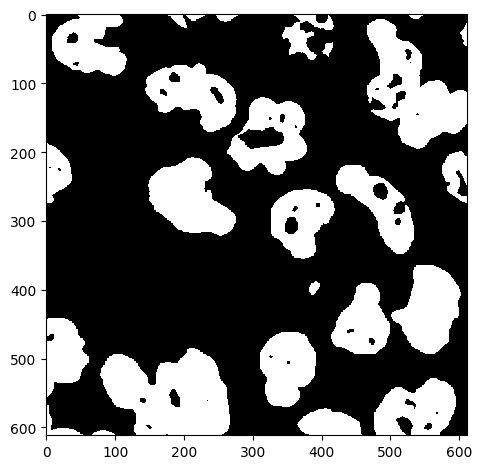

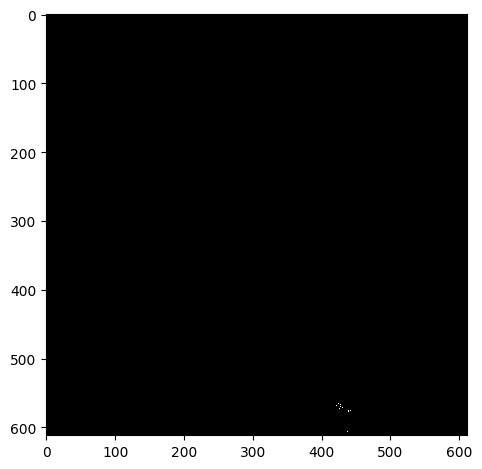

251024_PFF_SCR_TAX_ADAM\WT_SCR_07.czi


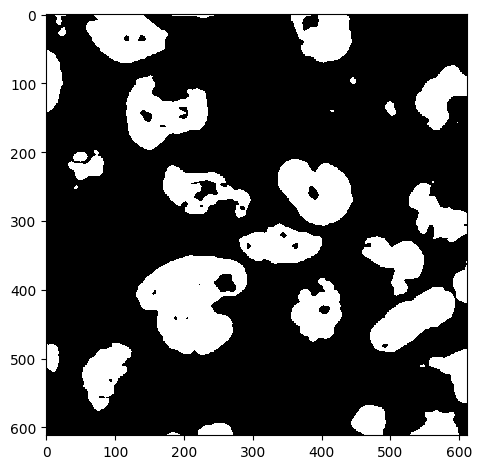

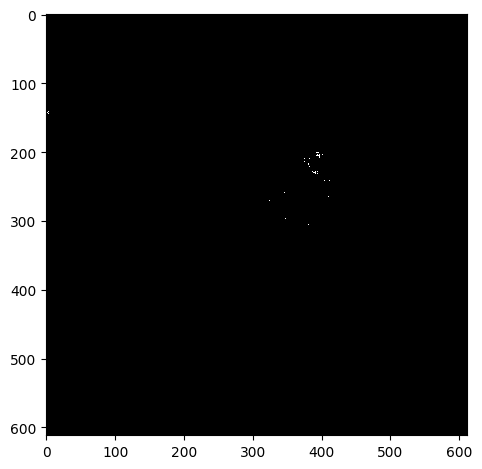

251024_PFF_SCR_TAX_ADAM\WT_SCR_08.czi


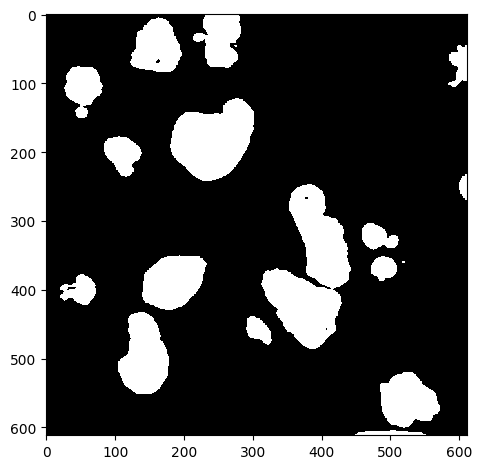

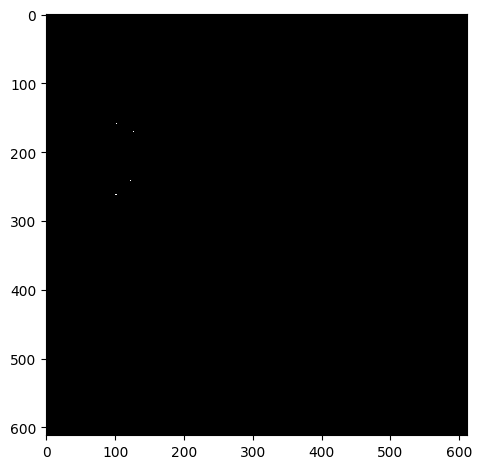

251024_PFF_SCR_TAX_ADAM\WT_SCR_09.czi


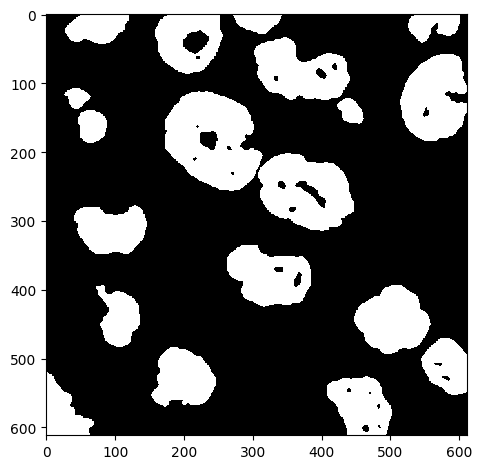

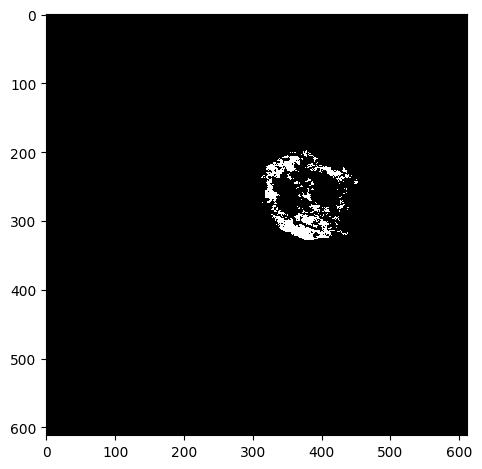

251024_PFF_SCR_TAX_ADAM\WT_SCR_10.czi


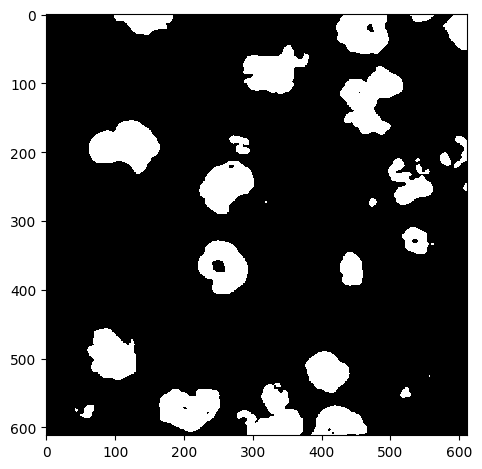

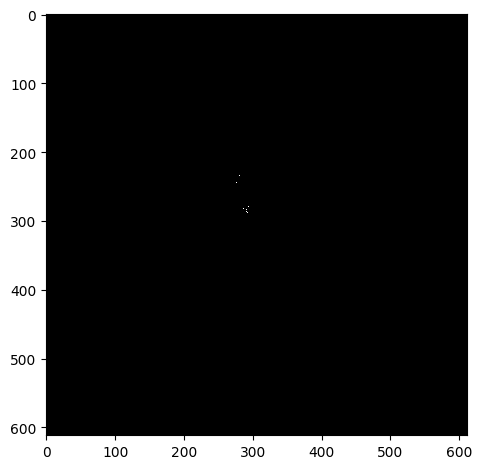

251024_PFF_SCR_TAX_ADAM\WT_TAX1BP1_01.czi


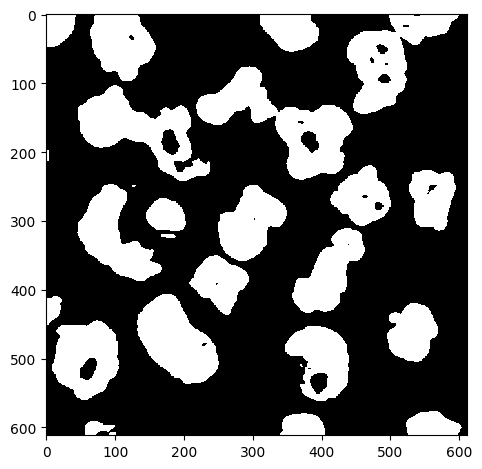

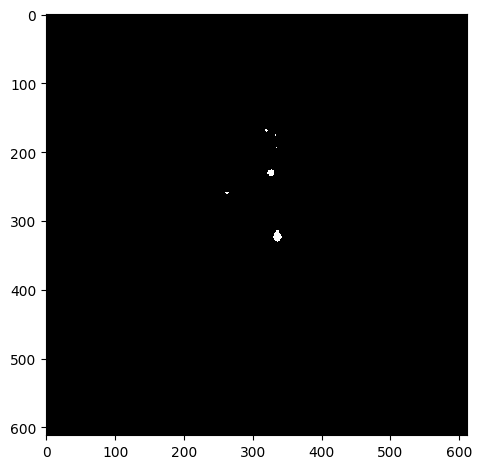

251024_PFF_SCR_TAX_ADAM\WT_TAX1BP1_02.czi


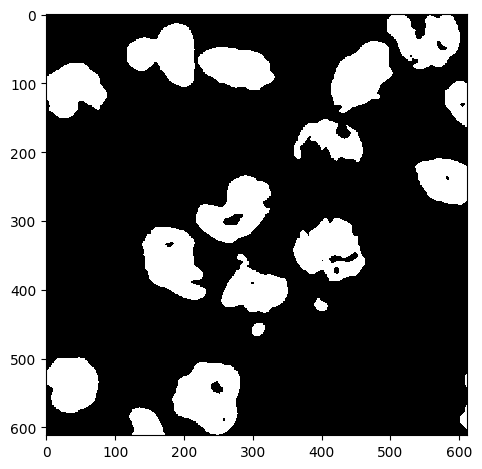

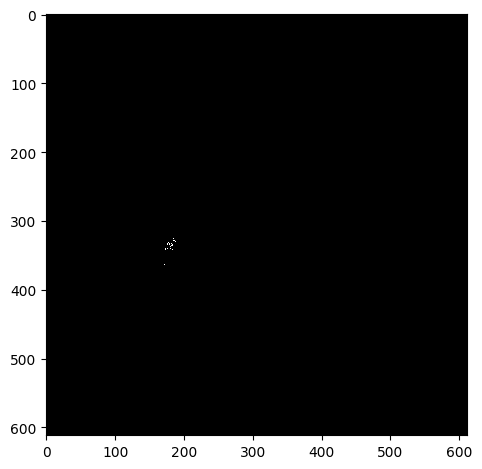

251024_PFF_SCR_TAX_ADAM\WT_TAX1BP1_03.czi


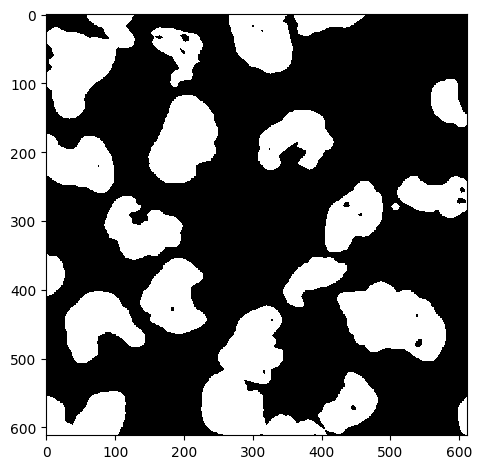

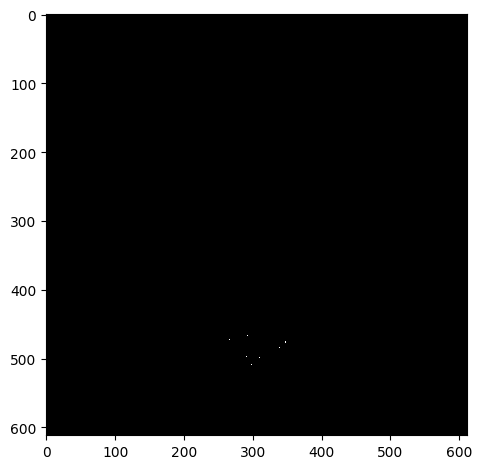

251024_PFF_SCR_TAX_ADAM\WT_TAX1BP1_04.czi


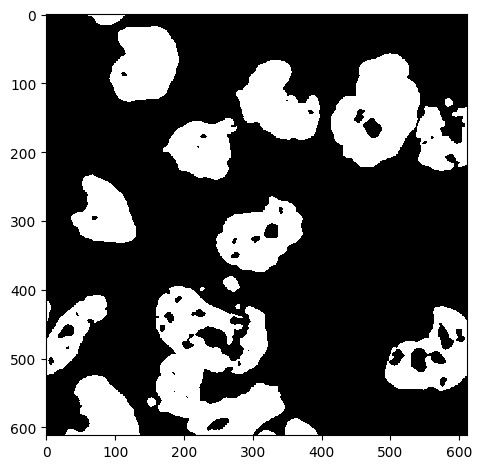

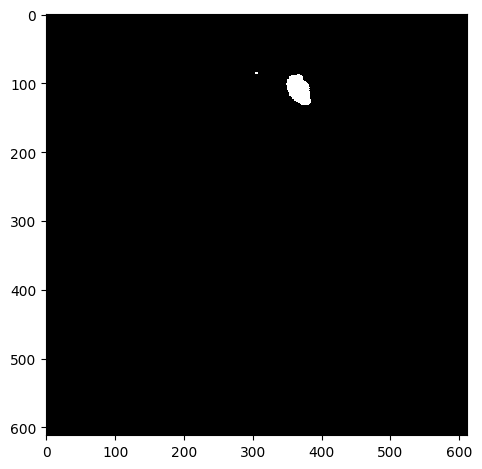

251024_PFF_SCR_TAX_ADAM\WT_TAX1BP1_05.czi


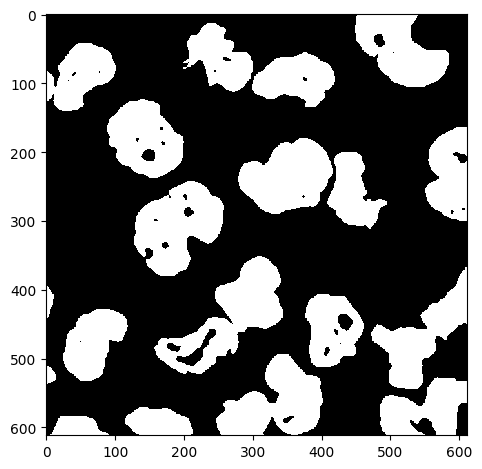

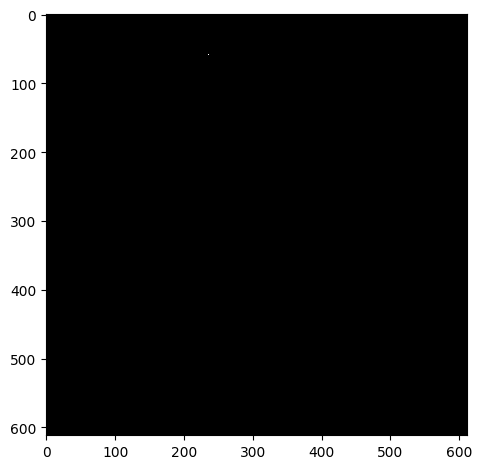

251024_PFF_SCR_TAX_ADAM\WT_TAX1BP1_06.czi


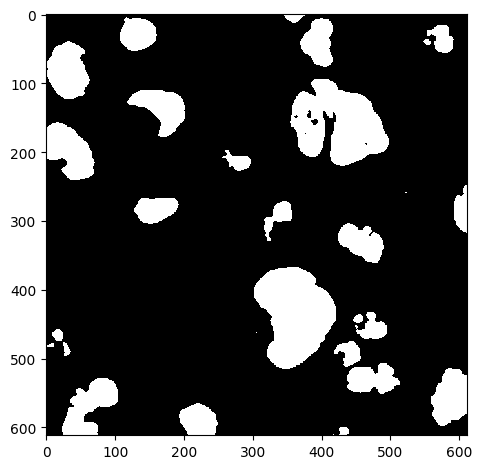

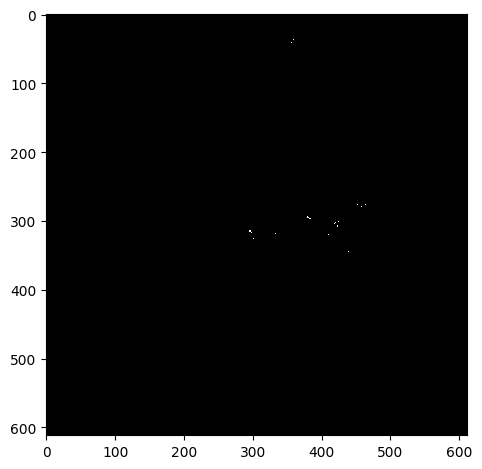

251024_PFF_SCR_TAX_ADAM\WT_TAX1BP1_07.czi


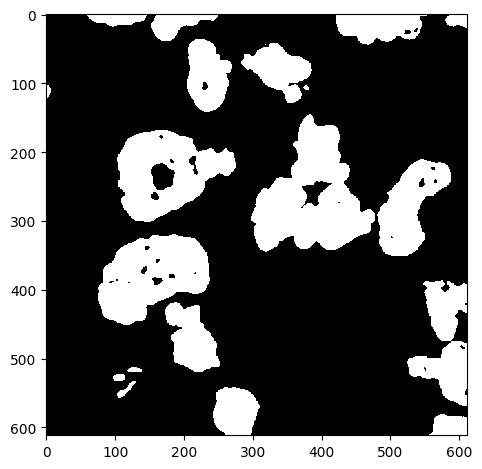

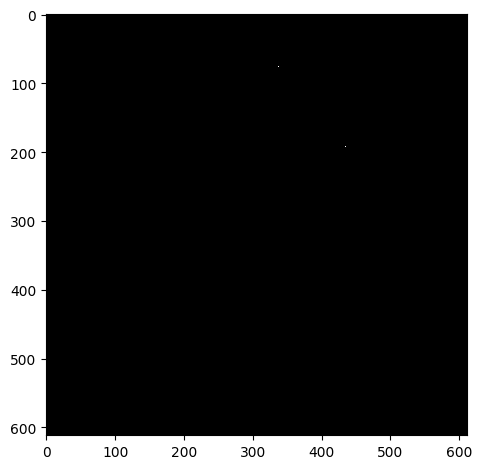

251024_PFF_SCR_TAX_ADAM\WT_TAX1BP1_08.czi


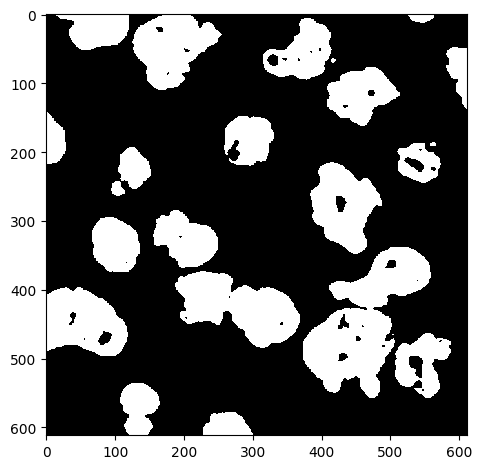

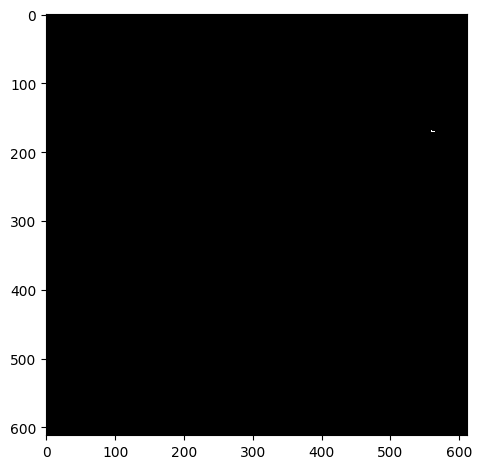

251024_PFF_SCR_TAX_ADAM\WT_TAX1BP1_09.czi


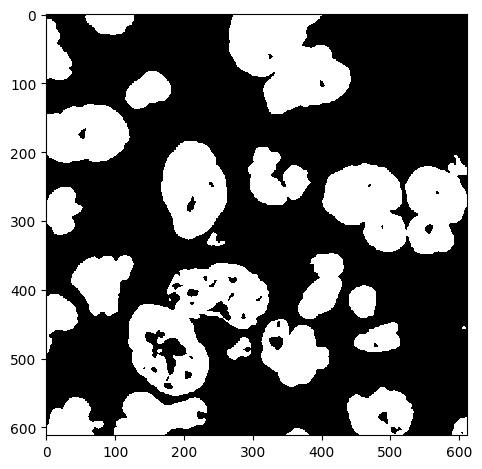

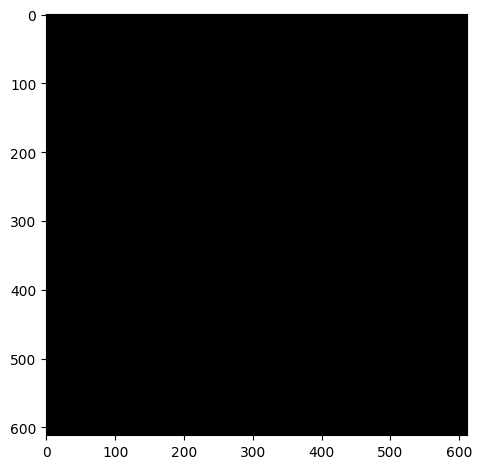

251024_PFF_SCR_TAX_ADAM\WT_TAX1BP1_10.czi


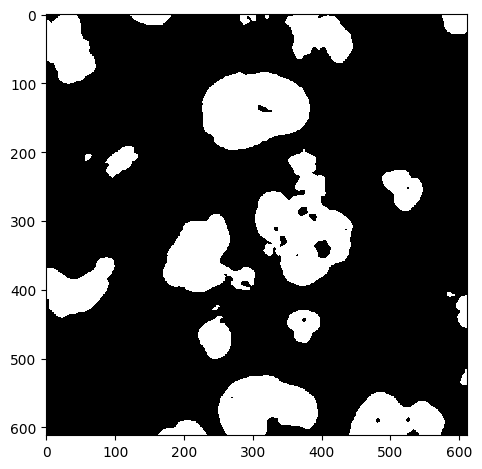

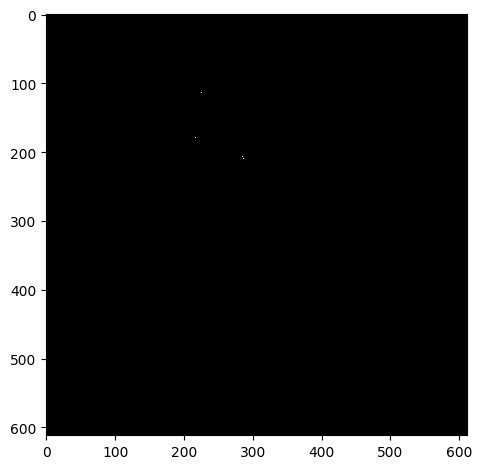

In [97]:
def main(image_folder):
    # Initialize lists to store results
    number_of_nuclei_list = []
    sizes_df_new = None

    images_to_analyze = extract_image_paths(image_folder)

    # Iterate over each image
    for path in images_to_analyze:
        print(path)
        dapi_channel, green_channel = read_czi_image(path)
        
        # Process DAPI channel for nuclei counting
        labeled_image_dapi = preprocess_dapi_channel(dapi_channel)

        n_nuclei = count_nuclei(labeled_image_dapi)
        number_of_nuclei_list.append(n_nuclei)

        # Process green channel for inclusion quantification
        confocal_img = preprocess_green_channel(green_channel)
        
        labeled_image_inclusions = threshold_inclusions(confocal_img)
        
        
        inclusion_sizes = measure_inclusion_sizes(labeled_image_inclusions, confocal_img)

        # Add to DataFrame
        sizes_df_new = add_to_dataframe(sizes_df_new, inclusion_sizes, os.path.basename(path))

    # Calculate metrics and save results
    
    excel_2 = calculate_metrics(number_of_nuclei_list, sizes_df_new)
    excel_2.to_excel(f"PFF_Inclusion_Count_{image_folder[:6]}.xlsx")

    excel_3 = calculate_sizes(sizes_df_new)
    excel_3.to_excel(f"PFF_Inclusion_Size_{image_folder[:6]}.xlsx",index=False)

if __name__ == "__main__":
    
    image_folder = '251024_PFF_SCR_TAX_ADAM' # threshold = 0.95
    # image_folder = '291024_PFF_SCR_TAX_ADAM_780' # threshold = 0.95
    main(image_folder)
